In [95]:
from src.utils import *
import os
import IPython.display as ipd
import logging
import librosa
import gc
from src.resnet_model import SpectrogramModel
from src.resnet_utils import LoadAttackData_ResNet
from src.resnet_features import compute_spectrum
from sp_utils import recover_mag_spec, retrieve_single_audio
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch.nn as nn
import librosa
import time
from attacks.sp_utils import spectrogram_inversion_batch
from attacks_utils import save_perturbed_audio

logging.getLogger('numba').setLevel(logging.WARNING)
logging.getLogger('matplotlib.font_manager').disabled = True
logging.getLogger('matplotlib.colorbar').disabled = True
logging.getLogger('matplotlib.pyplot').disabled = True

In [96]:
seed_everything(1234)
set_gpu(-1)
plt.style.use('dark_background')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
config_path = '../config/residualnet_train_config.yaml'
config = read_yaml(config_path) 
df_eval = pd.read_csv(os.path.join('..', config['df_eval_path_3s']))

model = SpectrogramModel().to(device)
model.load_state_dict(torch.load(os.path.join('..', config['model_path_spec_pow']), map_location=device), strict=False)
model.eval()

GPU selected: 0 - NVIDIA GeForce GTX 1080


SpectrogramModel(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (block1): ResNetBlock(
    (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (lrelu): LeakyReLU(negative_slope=0.01)
    (dropout): Dropout(p=0.5, inplace=False)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1))
    (conv11): Conv2d(32, 32, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1))
  )
  (mp): MaxPool2d(kernel_size=3, stride=3, padding=1, dilation=1, ceil_mode=False)
  (block2): ResNetBlock(
    (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (lrelu): LeakyReLU(negative_slope=0.01)
    (dropout): Dropout(p=0.5, inplace=False)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1))
    (conv11):

In [126]:
# load one file
file_number = 1398070
label = np.array([1])
path_to_original = f'/nas/public/dataset/asvspoof2019/LA/ASVspoof2019_LA_eval/flac/LA_E_{file_number}.flac'
clean_audio, _ = librosa.load(path_to_original, sr=16000)

In [120]:
print('Original Audio Length: ', len(clean_audio))

Original Audio Length:  65260


In [121]:
ipd.Audio(clean_audio, rate=16000)

In [100]:
 # phase
phase = np.angle(librosa.stft(y=clean_audio, n_fft=2048, hop_length=512, center=False))
phase = phase[:, :84]

In [101]:
# compute power spectrogram
s = librosa.core.stft(clean_audio, n_fft=2048, win_length=2048, hop_length=512, center=False)
s = s[:, :84]
a = np.abs(s) ** 2
a = librosa.power_to_db(a)

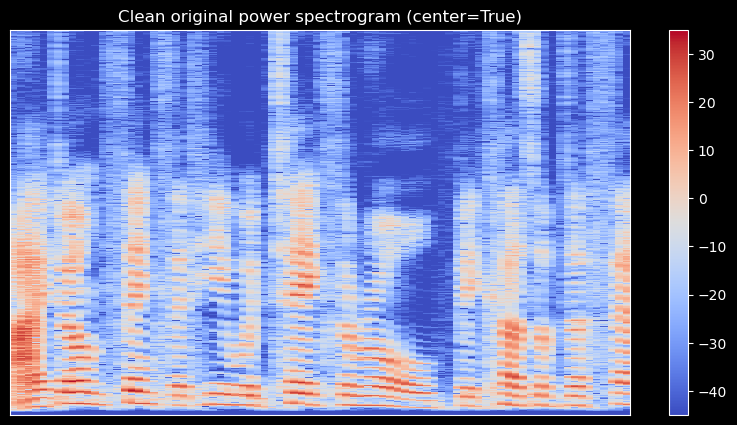

In [102]:
plt.figure(figsize=(10,5))
librosa.display.specshow(a, sr=16000)
plt.colorbar()
plt.title('Clean original power spectrogram (center=True)')
plt.show()

In [131]:
# attack
batch_x = torch.from_numpy(a).unsqueeze(dim=0).to(device)
batch_x.requires_grad = True
out = model(batch_x)

print(f'Model prediction is {torch.argmax(out)}')

Model prediction is 1


In [132]:
batch_y = torch.from_numpy(label).to(device)
L = nn.NLLLoss()
loss = L(out, batch_y)
model.zero_grad()
loss.backward()
grad = batch_x.grad.data

In [133]:
eps_low = 4.0
eps_high = 2.0
batch_low = batch_x[:1025//2,:]
batch_high = batch_x[1025//2:,:]
grad_low = grad[:1025//2,:]
grad_high = grad[1025//2:,:]
p_batch_low = batch_low + eps_low*grad_low.sign()
p_batch_high = batch_high + eps_high*grad_high.sign()
p_batch = torch.cat((p_batch_low, p_batch_high), dim=0)

In [141]:
out_ = model(p_batch)
out_

tensor([[  0.0000, -34.3828]], device='cuda:0', grad_fn=<LogSoftmaxBackward0>)

In [137]:
a = p_batch.squeeze(dim=0).detach().cpu().numpy()

In [138]:
# recover spec
lin_a = librosa.db_to_power(a)
mag_a = np.sqrt(lin_a)
print(f'Shape of spec a: {mag_a.shape}')


Shape of spec a: (1025, 84)


In [139]:
rec_a = librosa.istft(mag_a * np.exp(1j * phase), n_fft=2048, hop_length=512)

In [142]:
ipd.Audio(rec_a, rate=16000)


In [143]:
len(rec_a)

42496

In [144]:
#TODO check how this transfers to audio